Student: Duncan Ferguson <br>
Student Id: 871641260 <br>
Class: Comp 4431-1 <br>
Assignment: Assignment 3 <br>
Date: 11/20/2021 <br>

You are to apply the following techniques to mine this data set:

- Association Rules
- Decision tree Classification
- Naive Bayes Classification
- kmeans and dbscan clustering

Also, you are to use Principle Component Analysis to reduce the number of attributes (aka features)

## 1. What can you deduce from the data set? (in otherwords, what attribute values are indicative of "success")

poutcome and campaign are very indicative of success. This makes sense as poutcome is people that subscribed before
and campaign is the type of campaign that they are targeted with. Association rules did not find anything any rules
that were actually interesting or strong with relation to predicting success. The Decision tree gave the best results
followed by the Gaussian Model. K-means and DBscan seemed to be a bit lacking which was probably due to the fact
that there were a lot of features.


## 2. Which mining techniques yielded the best results for what? How do you define "best results"?
Best result is defined by the highest accuracy

The technique that yielded the best results was running a backward selection with
a decision tree. <br>
Accuracy: 0.8911865531350216
Features: ['poutcome', 'campaign'] <br>

This makes the most sense on the campaign being successful. They had previously subscribed. And the type
of campaign that is run predicted if they would subscribe.

This was followed up by decision tree using the forward model selection which added a few features.
Accuracy: 0.8916288842198385
Add Feature: contact <br>
Model Features ['contact', 'poutcome', 'campaign', 'loan'] <br>
Contact and Loan seem to have added to the forward selection. This is due to me just dropping values in the
backward selection model that made the model drop the first value that

The backward model selection with the gaussian found the most accurate model to just be:
Accuracy: 0.8824505142098861 <br>
Features: ['campaign']  <br>


### 3. How useful was Principle Component Analysis? For what number of components did you get the "best results."
### TODO ANSWER GERE
PCA was alright. There was a variety of different answers. There was an even spread and it did not contain a noticable
dip that made it easy to just cut off the data. It was useful for DBSCAN and K-means Clustering to aid in the
visualization. The PCA only explained about 33 percent of the variation with only three features. If there was a more
noticable dip instead of a even spread on the features determining variation I would have ben able to utilize it
a bit more.

Please include tables and/or graphs to justify your statements about which are best. <br>
All of the graphs and tables are below following with the analysis.

### Start of The Code
Main Library Imports Below

In [301]:
import graphviz
import pandas as pd
import numpy as np
from csv import reader

# Sklearn Libraries
from sklearn import tree
from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn.metrics import *
from sklearn.naive_bayes import *
from sklearn.cluster import KMeans, DBSCAN
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.tree import export_graphviz, export_text
import pydotplus

# Importing mlxtend Libraries
from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder

# Graphing Libraries
import matplotlib.pyplot as plt
import seaborn as sns

Importing the main document <br>
Setting the random seed and setting view options <br>

In [302]:
np.random.seed(0)
df =  pd.read_csv("bank-full.csv")

pd.set_option('display.max_columns', None)
pd.set_option('max_columns', None)
pd.set_option('max_rows', None)
pd.options.display.width = 0   # automatically ajust to window length

df_a = df.copy()
df_b = df.copy()

In [303]:
df_a.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


### Association Rule Analysis Below
### Feature Engineering
First Cleaning up the data and creating categories

In [304]:
for index, row in df_a.iterrows():
	if row['balance'] < 0:
		row['balance'] = 'inDebt'
	else:
		row['balance'] = 'notInDebt'

# Creating Categories for balance
df_a.loc[(df_a['balance'] >= 10000), 'balanceSummary'] = 'veryPositive'
df_a.loc[((df_a['balance'] < 0) & (df_a['balance'] >= -10000)), 'balanceSummary'] = 'negative'
df_a.loc[((df_a['balance'] < 10000) & (df_a['balance'] >= 0)), 'balanceSummary'] = 'positive'
df_a.loc[df_a['balance'] < -500, 'balanceSummary'] = 'veryNegative'

# Creating Categories for ages
df_a.loc[((df_a['age'] < 25) & (df_a['age'] >= 0)),  'ageBand'] = 'ageBand1'
df_a.loc[((df_a['age'] < 30) & (df_a['age'] >= 25)), 'ageBand'] = 'ageBand2'
df_a.loc[((df_a['age'] < 40) & (df_a['age'] >= 30)), 'ageBand'] = 'ageBand3'
df_a.loc[((df_a['age'] < 50) & (df_a['age'] >= 40)), 'ageBand'] = 'ageBand4'
df_a.loc[((df_a['age'] < 120) & (df_a['age'] >= 50)),'ageBand'] = 'ageBand5'

# Creating Categories for default
df_a.loc[(df_a['default'] == 'no'), 'defaultValue'] = 'defaultNo'
df_a.loc[(df_a['default'] == 'yes'), 'defaultValue'] = 'defaultYes'

# Creating Categories for Housing
df_a.loc[(df_a['housing'] == 'no'), 'housingVal'] = 'houseNo'
df_a.loc[(df_a['housing'] == 'yes'), 'housingVal'] = 'houseYes'

# Creating Categories for Loans
df_a.loc[(df_a['loan'] == 'no'), 'loanVal'] = 'loanNo'
df_a.loc[(df_a['loan'] == 'yes'), 'loanVal'] = 'loanYes'

# Dropping all values that are not strings
df_a = df_a.drop(['age', 'day', 'duration', 'balance', 'campaign', 'previous', 'default', 'housing', 'loan', 'pdays'],
                 axis=1)

# Displaying Head
df_a.head()

,job,marital,education,contact,month,poutcome,y,balanceSummary,ageBand,defaultValue,housingVal,loanVal
0,management,married,tertiary,unknown,may,unknown,no,positive,ageBand5,defaultNo,houseYes,loanNo
1,technician,single,secondary,unknown,may,unknown,no,positive,ageBand4,defaultNo,houseYes,loanNo
2,entrepreneur,married,secondary,unknown,may,unknown,no,positive,ageBand3,defaultNo,houseYes,loanYes
3,blue-collar,married,unknown,unknown,may,unknown,no,positive,ageBand4,defaultNo,houseYes,loanNo
4,unknown,single,unknown,unknown,may,unknown,no,positive,ageBand3,defaultNo,houseNo,loanNo


Displaying all the Unique Values

In [305]:
for col in df_a:
    print(col, ":", df_a[col].unique())

job : ['management' 'technician' 'entrepreneur' 'blue-collar' 'unknown'
 'retired' 'admin.' 'services' 'self-employed' 'unemployed' 'housemaid'
 'student']
marital : ['married' 'single' 'divorced']
education : ['tertiary' 'secondary' 'unknown' 'primary']
contact : ['unknown' 'cellular' 'telephone']
month : ['may' 'jun' 'jul' 'aug' 'oct' 'nov' 'dec' 'jan' 'feb' 'mar' 'apr' 'sep']
poutcome : ['unknown' 'failure' 'other' 'success']
y : ['no' 'yes']
balanceSummary : ['positive' 'negative' 'veryPositive' 'veryNegative']
ageBand : ['ageBand5' 'ageBand4' 'ageBand3' 'ageBand2' 'ageBand1']
defaultValue : ['defaultNo' 'defaultYes']
housingVal : ['houseYes' 'houseNo']
loanVal : ['loanNo' 'loanYes']


Exporting the dataframe as a CSV and reimporting it to speed up run times.

In [306]:
df_a.to_csv("outfile.csv", index=False)
file = []
with open("outfile.csv", 'r') as read_obj:
    csv_reader = reader(read_obj)
    for row in csv_reader:
        file.append(row)

Creating transact 1 hot boolean encoded numpy array and displaying dataframe head

In [307]:
te = TransactionEncoder()
te_ary = te.fit(file).transform(file)
df_a_encoded = pd.DataFrame(te_ary, columns=te.columns_)
df_a_encoded.head()

,admin.,ageBand,ageBand1,ageBand2,ageBand3,ageBand4,ageBand5,apr,aug,balanceSummary,blue-collar,cellular,contact,dec,defaultNo,defaultValue,defaultYes,divorced,education,entrepreneur,failure,feb,houseNo,houseYes,housemaid,housingVal,jan,job,jul,jun,loanNo,loanVal,loanYes,management,mar,marital,married,may,month,negative,no,nov,oct,other,positive,poutcome,primary,retired,secondary,self-employed,sep,services,single,student,success,technician,telephone,tertiary,unemployed,unknown,veryNegative,veryPositive,y,yes
0,False,True,False,False,False,False,False,False,False,True,False,False,True,False,False,True,False,False,True,False,False,False,False,False,False,True,False,True,False,False,False,True,False,False,False,True,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False
1,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,True,False,False,True,True,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,True,False,False,False,False
2,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,True,False,False,False,True,False,False,False,True,False,False,False,True,False,False,True,False,False,False,True,False,False,False,False
3,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,True,True,False,False,True,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False
4,False,False,False,False,False,True,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,True,True,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False


Creating Filter Function for frequent Item Sets

In [308]:
def filter_freq_items(freq_items,items=1):
    """This function filters the frequent items so that we can look a certain n-itemsets"""
    filtered_freq_items = freq_items[freq_items["length"] == items].copy()
    return filtered_freq_items

Creating Frequent Items List and Association Rules

In [309]:
# Creating Frequent Items List
freq_items = apriori(df_a_encoded, min_support=.5, use_colnames=True)
freq_items['length'] = freq_items['itemsets'].apply(lambda x: len(x))
freq_items.sort_values(["support", "length"], inplace=True, ascending=False)
freq_items.head(10)

,support,itemsets,length
1,0.981952,(defaultNo),1
6,0.898346,(positive),1
17,0.890073,"(defaultNo, positive)",2
5,0.882996,(no),1
16,0.866120,"(defaultNo, no)",2
3,0.839755,(loanNo),1
14,0.828386,"(defaultNo, loanNo)",2
8,0.826528,(unknown),1
19,0.809741,"(defaultNo, unknown)",2
27,0.788994,"(no, positive)",2


In [310]:
# Creating Association Rules
rules = association_rules(freq_items, metric="confidence", min_threshold=0.3)
rules.sort_values(["lift"], inplace=True, ascending=False)
rules.head(10)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
233,(houseYes),"(defaultNo, no)",0.555826,0.866120,0.504048,0.906844,1.047020,0.022636,1.437170
228,"(defaultNo, no)",(houseYes),0.866120,0.555826,0.504048,0.581961,1.047020,0.022636,1.062518
227,(no),(houseYes),0.882996,0.555826,0.513028,0.581008,1.045306,0.022236,1.060102
226,(houseYes),(no),0.555826,0.882996,0.513028,0.923000,1.045306,0.022236,1.519545
232,(no),"(defaultNo, houseYes)",0.882996,0.546205,0.504048,0.570838,1.045100,0.021751,1.057399
229,"(defaultNo, houseYes)",(no),0.546205,0.882996,0.504048,0.922818,1.045100,0.021751,1.515961
176,"(defaultNo, no, loanNo)","(unknown, positive)",0.722928,0.738830,0.557463,0.771118,1.043701,0.023342,1.141068
177,"(unknown, positive)","(defaultNo, no, loanNo)",0.738830,0.722928,0.557463,0.754520,1.043701,0.023342,1.128699
185,"(no, loanNo)","(defaultNo, unknown, positive)",0.733478,0.731045,0.557463,0.760027,1.039644,0.021257,1.120770
168,"(defaultNo, unknown, positive)","(no, loanNo)",0.731045,0.733478,0.557463,0.762556,1.039644,0.021257,1.122463


### Association rules analysis
Below are different tables that show the break down of the frequent item sets
#### Frequent Items

In [311]:
filter_freq_items(freq_items,5)

,support,itemsets,length
51,0.557463,"(positive, unknown, no, defaultNo, loanNo)",5


In [312]:
filter_freq_items(freq_items,4)

,support,itemsets,length
46,0.660444,"(defaultNo, no, positive, loanNo)",4
49,0.659692,"(defaultNo, unknown, no, positive)",4
48,0.622180,"(defaultNo, unknown, positive, loanNo)",4
47,0.611298,"(defaultNo, unknown, no, loanNo)",4
50,0.562107,"(unknown, no, positive, loanNo)",4


In [313]:
filter_freq_items(freq_items,3).head(10)

,support,itemsets,length
39,0.781253,"(defaultNo, no, positive)",3
35,0.760440,"(defaultNo, positive, loanNo)",3
40,0.733323,"(defaultNo, unknown, no)",3
41,0.731045,"(defaultNo, unknown, positive)",3
34,0.722928,"(defaultNo, no, loanNo)",3
36,0.679842,"(defaultNo, unknown, loanNo)",3
45,0.666991,"(unknown, no, positive)",3
42,0.665399,"(no, positive, loanNo)",3
44,0.627157,"(unknown, positive, loanNo)",3
43,0.621096,"(unknown, no, loanNo)",3


In [314]:
filter_freq_items(freq_items,2).head(10)

,support,itemsets,length
17,0.890073,"(defaultNo, positive)",2
16,0.866120,"(defaultNo, no)",2
14,0.828386,"(defaultNo, loanNo)",2
19,0.809741,"(defaultNo, unknown)",2
27,0.788994,"(no, positive)",2
22,0.765770,"(positive, loanNo)",2
28,0.749049,"(unknown, no)",2
29,0.738830,"(unknown, positive)",2
21,0.733478,"(no, loanNo)",2
23,0.690392,"(unknown, loanNo)",2


After breaking down the frequent item sets it is interesting to learn that there is only
1 frequent item set that contains 5 words with a support over 5. This will make our cluster analysis
a bit more interesting later. With that said.
Positive balance, unknown job, no default and no loan is not is not likely to subscribe
at least with a .557463 support.

It is also interesting to see that the majority of the frequent item sets contain "no" meaning
that they are not likely to subscribe. The majority of the banks customers had defaultno with a
positive balance summary, or were not likely to subscribe.

It is also interesting to see that yes is not included in the frequent item sets. meaning that
the majority of people that say yes do not have a whole lot in common with others that said yes

#### Association rules

In [315]:
rules.sort_values('lift', ascending=False).head(5)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
233,(houseYes),"(defaultNo, no)",0.555826,0.866120,0.504048,0.906844,1.047020,0.022636,1.437170
228,"(defaultNo, no)",(houseYes),0.866120,0.555826,0.504048,0.581961,1.047020,0.022636,1.062518
227,(no),(houseYes),0.882996,0.555826,0.513028,0.581008,1.045306,0.022236,1.060102
226,(houseYes),(no),0.555826,0.882996,0.513028,0.923000,1.045306,0.022236,1.519545
232,(no),"(defaultNo, houseYes)",0.882996,0.546205,0.504048,0.570838,1.045100,0.021751,1.057399


The top 5 most interesting rules, defined by the highest lift values is that homeowners
are not likely to default and subscribe. This not exactly shocking to find out. It is intresting to see
that the lift values are not extremely high.

In [316]:
rules.sort_values('confidence', ascending=False).head(5)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
20,"(positive, loanNo)",(defaultNo),0.765770,0.981952,0.760440,0.993039,1.011291,0.008490,2.592815
71,"(no, positive, loanNo)",(defaultNo),0.665399,0.981952,0.660444,0.992554,1.010797,0.007055,2.423952
107,"(unknown, positive, loanNo)",(defaultNo),0.627157,0.981952,0.622180,0.992065,1.010299,0.006343,2.274488
163,"(unknown, no, positive, loanNo)",(defaultNo),0.562107,0.981952,0.557463,0.991737,1.009965,0.005500,2.184189
210,"(married, positive)",(defaultNo),0.541206,0.981952,0.536694,0.991663,1.009890,0.005256,2.164823


Looking at the top five strong rules reveals th default no has the strongest confidence if
the antecedents are, loanNo, positive bank account  and are married or have an unknown job.

Unfortunately these word associations are not leading us to find anything that is helping find rules
that are indicative of a successful campaign. It is for that reason that I will continue data mining with the
remain algorithms.

### Feature Engineering for the following algorithms
- Decision tree Classification
- Naive Bayes Classification

First we must take all the data and numericalize it

In [317]:
# Creating Categories for ages then making categories
df_b['job'] = df_b['job'].astype('category')
df_b['job'] = df_b['job'].cat.codes
df_b['marital'] = df_b['marital'].astype('category')
df_b['marital'] = df_b['marital'].cat.codes
df_b['education'] = df_b['education'].astype('category')
df_b['education'] = df_b['education'].cat.codes
df_b['default'] = df_b['default'].astype('category')
df_b['default'] = df_b['default'].cat.codes
df_b['contact'] = df_b['contact'].astype('category')
df_b['contact'] = df_b['contact'].cat.codes
df_b['month'] = df_b['month'].astype('category')
df_b['month'] = df_b['month'].cat.codes
df_b['poutcome'] = df_b['poutcome'].astype('category')
df_b['poutcome'] = df_b['poutcome'].cat.codes
df_b['housing'] = df_b['housing'].astype('category')
df_b['housing'] = df_b['housing'].cat.codes
df_b['loan'] = df_b['loan'].astype('category')
df_b['loan'] = df_b['loan'].cat.codes
df_b['y'] = df_b['y'].astype('category')
df_b['y'] = df_b['y'].cat.codes
df_b = df_b.drop('pdays',axis=1)
df_b['balance'] = (df_b['balance'] - df_b['balance'].min()) / ( df_b['balance'].max() - df_b['balance'].min())
print("Post Conversion of Data into numeric, dropping pdays, and normalizing balance:")
df_b.head(10)

Post Conversion of Data into numeric, dropping pdays, and normalizing balance:


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,previous,poutcome,y
0,58,4,1,2,0,0.092259,1,0,2,5,8,261,1,0,3,0
1,44,9,2,1,0,0.073067,1,0,2,5,8,151,1,0,3,0
2,33,2,1,1,0,0.072822,1,1,2,5,8,76,1,0,3,0
3,47,1,1,3,0,0.086476,1,0,2,5,8,92,1,0,3,0
4,33,11,2,3,0,0.072812,0,0,2,5,8,198,1,0,3,0
5,35,4,1,2,0,0.074901,1,0,2,5,8,139,1,0,3,0
6,28,4,2,2,0,0.076862,1,1,2,5,8,217,1,0,3,0
7,42,2,0,2,1,0.072822,1,0,2,5,8,380,1,0,3,0
8,58,5,1,0,0,0.073902,1,0,2,5,8,50,1,0,3,0
9,43,9,2,1,0,0.078187,1,0,2,5,8,55,1,0,3,0


#### Exploratory Data Analysis
Now that we have numericalized the data it is time to do some preliminary exploration

<AxesSubplot:>

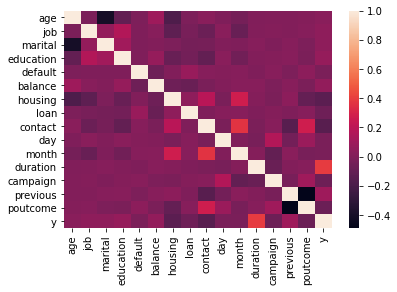

In [318]:
sns.heatmap(df_b.corr())

In [319]:
df_b.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 16 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   age        45211 non-null  int64  
 1   job        45211 non-null  int8   
 2   marital    45211 non-null  int8   
 3   education  45211 non-null  int8   
 4   default    45211 non-null  int8   
 5   balance    45211 non-null  float64
 6   housing    45211 non-null  int8   
 7   loan       45211 non-null  int8   
 8   contact    45211 non-null  int8   
 9   day        45211 non-null  int64  
 10  month      45211 non-null  int8   
 11  duration   45211 non-null  int64  
 12  campaign   45211 non-null  int64  
 13  previous   45211 non-null  int64  
 14  poutcome   45211 non-null  int8   
 15  y          45211 non-null  int8   
dtypes: float64(1), int64(5), int8(10)
memory usage: 2.5 MB


From the Correlation Map we can see that Y has a high correlation with marital status followed by education and housing.


Now to split the data into training sets and do some more exploration. But first we will split the data into
feature{x} and outcome{y}. Followed by a quick heatmap, just go get a vizualization of the features correlated to
themselves

<AxesSubplot:>

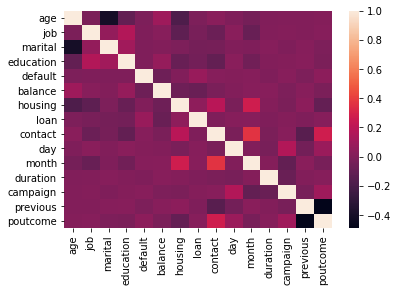

In [320]:
y = df_b["y"]
X = df_b.drop("y", axis=1)

# Standardizing the feature data
X[X.columns] = StandardScaler().fit_transform(X)
sns.heatmap(X.corr())

In [321]:
# Splitting the dataset into Train Set and Test Set
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=0)

#### PCA Analysis
The Principal Component Analysis Will help use look to see how many variables affect our algorithm
to see if we can include less features to help speed up run times.

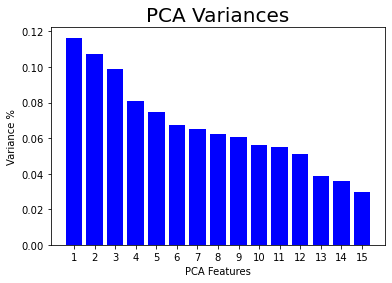

In [322]:
# Standardizing the Data
pca = PCA(n_components=15)
principalComponents = pca.fit_transform(X)

#Plotting the explained variances
features = range(1,pca.n_components_+1)
plt.bar(features, pca.explained_variance_ratio_, color='b')
plt.xlabel('PCA Features')
plt.ylabel('Variance %')
plt.xticks(features)
plt.title("PCA Variances", fontsize=20)
plt.show()

In [323]:
# First Three Feature variance Explanation
sum(pca.explained_variance_ratio_[:3])

0.322735471272194

This first graph of the PCA's shows us a constant decline in variance. There is a bit of a dip around the first three
give us an explanation of about 32%.

Next Graph will show us the cumulative PCA

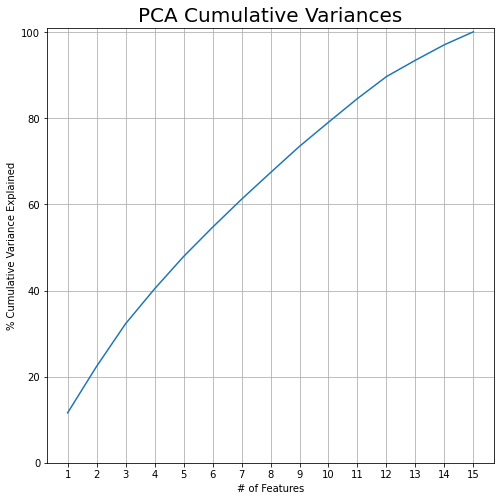

In [324]:
var = np.cumsum(np.round(pca.explained_variance_ratio_, 3)*100)
plt.figure(figsize=(8,8))

plt.title('PCA Cumulative Analysis')
plt.ylim(0,101)
plt.xticks(features)
plt.ylabel('% Cumulative Variance Explained')
plt.xlabel('# of Features')
plt.title("PCA Cumulative Variances", fontsize=20)
plt.plot(features, var)
plt.grid()
plt.show()

Looking at the cumulative PCA variance graph offers us the same insight. there is no major elbow that
makes limiting the amount of features drastically change. instead it gets closer and closer to explaining the variance
the more features that we add.

The next few graphs will go through looking at graphing the different amount of accuracy
for the both the GaussianNB model and decision trees.

In [325]:
def gather_model_accuracies(model_type, name):
    """This function takes in Different Classifiers to gather accuracies"""
    accuracy = []
    for i in range(1,16):
        pipe = Pipeline([('preprocessor', PCA(n_components=i, random_state=0)),
                         ('clf', model_type)])
        pipe.fit(X_train, y_train)
        y_prediction = pipe.predict(X_test)
        accuracy.append(accuracy_score(y_test, y_prediction))
    accuracy = pd.DataFrame(accuracy, index=[i for i in range(1,16)], columns=[name])
    return accuracy

The Function Below Graphs the Accuracies Gathered from above

In [326]:
def graph_accuracies(model_type, model_name):
    """This Function Graphs The Accuracies"""
    x = model_type.index.tolist()
    y = model_type.iloc[:,0].tolist()
    fig, ax = plt.subplots(1, figsize=(5,5))
    sns.lineplot(x=x, y=y, linewidth=4, color='b', ax=ax)
    ax.set_xlabel("Number of Features")
    ax.set_ylabel("Model Accuracy")
    plt.xticks(np.arange(min(x),max(x)+1))
    plt.title(str("Accuracy for " + model_name), fontsize=20)
    plt.grid()
    plt.show()


Gathering the Decision Tree and GaussianNB Model Accuracy

In [327]:
dtree_accuracy = gather_model_accuracies(tree.DecisionTreeClassifier(random_state=0), "Decision Tree")
dtree_accuracy

,Decision Tree
1,0.801946
2,0.806480
3,0.818865
4,0.823952
5,0.838107
6,0.839323
7,0.848944
8,0.846069
9,0.845848
10,0.846732


In [328]:
gnb_accuracy = gather_model_accuracies(GaussianNB(), "Gaussian")
gnb_accuracy

,Gaussian
1,0.882451
2,0.882451
3,0.881787
4,0.882008
5,0.882893
6,0.883335
7,0.885105
8,0.884883
9,0.885879
10,0.886321


Graphing the best features for the GaussianND and the Decision Tree Model

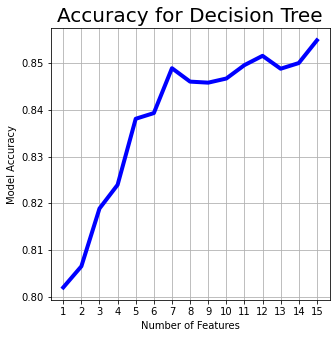

In [329]:
graph_accuracies(dtree_accuracy, "Decision Tree")

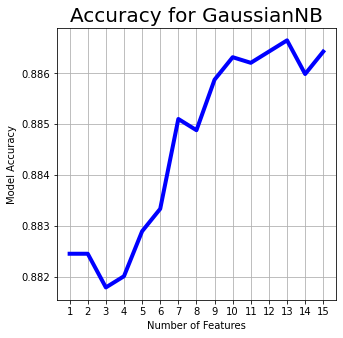

In [330]:
graph_accuracies(gnb_accuracy, "GaussianNB")

Looking at the two graphs above. It looks like there is a slight peak for the Decision tree at 7 features
then a valey, then another peak at 12 features with the total model accuracy being best at
15 features. The range for the accuracy is in between just above 80% with one features and 86% with
15 features.

For the GaussianNB Model the range of accuracies is in between 88.2% going all the way up to 88.65 %
There isolated peaks at 2 features, 7 features 10 and the highest accuracy being at 13 features.

Now that we have looked at these graphs. It's time to actually build some models and discover if we are
better at making some models.

The Next Few functions are set up so that I can run both the Decsion Tree and Gaussian Model with forward
and backward selection. Adding and taking away features.


In [331]:
def train_data(df, drops=None):
    """This Function splits the data to train and test the data. It also an element for being able to
    drop certain rows."""
    # Y is the classification
    Y = df['y'].tolist()
    X = df.copy()
    X = X.drop(columns=["y"])
    X[X.columns] = StandardScaler().fit_transform(X)
    if drops != None:
        X = X.drop(columns=drops)
    x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=0)
    return x_train, x_test, y_train, y_test, X

In [332]:
def decisionTree_Model(x_train, x_test, y_train, y_test, X, yes_print=False):
    """This Function goes through building a decision tree and creating a confusion matrix
    computing accuracy, and listing the decision tree features and their importance"""
    # Building out a decision tree
    dtree = tree.DecisionTreeClassifier(criterion="gini")
    dtree = dtree.fit(x_train, y_train)
    y_predicted = dtree.predict(x_test)
    accuracy = accuracy_score(y_test, y_predicted)
    important = dtree.feature_importances_
    df_importance_list = []
    for i, v in enumerate(important):
        df_importance_list.append([X.columns[i], v])
    df_importance = pd.DataFrame(df_importance_list, columns=["FName", "Score"])
    df_importance.sort_values(by=['Score'], ascending=False, inplace=True)
    decisionTree_Model_Features = df_importance["FName"].tolist()
    if yes_print:
        print("DecisionTree Accuracy: ", accuracy)
        print("DecisionTree Confusion Matrix:")
        print(confusion_matrix(y_test, y_predicted))
        print("decision tree dtree feature importance:")
        print(df_importance)
    return accuracy, decisionTree_Model_Features

In [333]:
def GausianNB_Model(x_train, x_test, y_train, y_test, X, yes_print=False):
    """This Function goes through the GausianNB model and calculates the accuracy, computes the confusion matrix
    and then lists the Gaussian Model Features and their significance"""
    model2 = GaussianNB()
    model2.fit(x_train, y_train)
    gausianNB_predicted = model2.predict(x_test)
    accuracy = accuracy_score(y_test, gausianNB_predicted)
    imps = permutation_importance(model2, x_test, y_test)
    df_Gausian_Feature_Importance_List = []
    Gausian_Feature_Importance_List =  imps.importances_mean.tolist()
    for row in enumerate(Gausian_Feature_Importance_List):
        df_Gausian_Feature_Importance_List.append([X.columns[row[0]], row[1]])
    df_Gausian_Feature_Importance = pd.DataFrame(df_Gausian_Feature_Importance_List, columns=["Feature", "Significance"])
    df_Gausian_Feature_Importance.sort_values(by=["Significance"], ascending=False, inplace=True)
    GausianND_Features = df_Gausian_Feature_Importance["Feature"].tolist()
    if yes_print:
        print('\nconfusion_matrix from Gaussian naive bayes:')
        print(confusion_matrix(y_test, gausianNB_predicted))
        print('accuracy = ' + str(accuracy))
        print("gausianNB feature importance:")
        print(df_Gausian_Feature_Importance)
    return accuracy, GausianND_Features

In [334]:
def backward_selection(accuracy, features, selection, df, model):
    """This is a backward selection model that removes one feature at a time to see if we can improve the
    accuracy of the model. Once any improvement is reached the function returns which feature that was dropped
    that improves the model. The features that were included and the accuracy of the new model"""
    features_loop = [word for word in features if word not in selection]
    accuracy_start = accuracy
    for feature in features_loop:
        x_train, x_test, y_train, y_test, X = train_data(df, [feature] + selection)  # Dropping selection and feature
        if model == 1:  # 1 For decisionTree
            new_accuracy, new_features = decisionTree_Model(x_train, x_test, y_train, y_test, X, False)
        else:
            new_accuracy, new_features = GausianNB_Model(x_train, x_test, y_train, y_test, X, False)
        if new_accuracy >= accuracy_start:
            print("Accuracy:", new_accuracy, "\nFeatures:", new_features,"\nDropped Feature:", feature)
            return
    return "No Improvement"

In [335]:
def forward_selection(accuracy, features, selection, df, model):
    """This is a backward selection model that removes one feature at a time to see if we can improve the
    accuracy of the model. Once any improvement is reached the function returns which feature that was dropped
    that improves the model. The features that were included and the accuracy of the new model"""
    features_loop = [word for word in features if word not in selection]
    best_accuracy = accuracy
    for feature in features_loop:
        drop_features = [word for word in features if word not in [feature] + selection]
        x_train, x_test, y_train, y_test, X = train_data(df, drop_features)  # Dropping selection and feature
        if model == 1:  # 1 For decisionTree
            new_accuracy, new_features = decisionTree_Model(x_train, x_test, y_train, y_test, X, False)
        else:
            new_accuracy, new_features = GausianNB_Model(x_train, x_test, y_train, y_test, X, False)
        if new_accuracy >= best_accuracy:
            best_accuracy = new_accuracy
            add_feature = feature
    if best_accuracy > accuracy:
            print("Accuracy:", best_accuracy, "\nAdd Feature:", add_feature, "\nModel Features", [add_feature] + selection)
    else:
        return "No Improvement"

Now To loop through. Starting Backwards with the Decision Tree Models

In [336]:
# Running the data back through the trainer
x_train, x_test, y_train, y_test, X = train_data(df_b)

# Decision Tree Model
dt_a, dt_f = decisionTree_Model(x_train, x_test, y_train, y_test, X, True)

DecisionTree Accuracy:  0.8625456153931218
DecisionTree Confusion Matrix:
[[7315  665]
 [ 578  485]]
decision tree dtree feature importance:
        FName     Score
11   duration  0.296549
5     balance  0.123322
10      month  0.102925
0         age  0.095055
9         day  0.094529
14   poutcome  0.060507
1         job  0.048802
13   previous  0.036116
12   campaign  0.033984
3   education  0.027874
6     housing  0.024090
8     contact  0.022019
2     marital  0.021672
7        loan  0.010346
4     default  0.002211


This first look gives us [duration, balance, month, age, day] the most important deciding factors.
To improve upon this model we will first step backwards to see if we can improve accuracy

In [337]:
features = df_b.columns.tolist()
features.pop(-1)
accuracy = 0.8625456153931218
selection = []

backward_selection(accuracy, features, selection, df_b, 1)

Accuracy: 0.871171071547053 
Features: ['duration', 'balance', 'month', 'day', 'poutcome', 'job', 'campaign', 'education', 'contact', 'marital', 'housing', 'previous', 'loan', 'default'] 
Dropped Feature: age


In [338]:
accuracy = 0.8625456153931218
selection = ['age']

backward_selection(accuracy, features, selection, df_b, 1)

Accuracy: 0.8686276678093553 
Features: ['duration', 'balance', 'month', 'day', 'poutcome', 'campaign', 'education', 'previous', 'marital', 'contact', 'housing', 'loan', 'default'] 
Dropped Feature: job


In [339]:
accuracy = 0.8678535884109255
selection = ['age','job']

backward_selection(accuracy, features, selection, df_b, 1)

Accuracy: 0.8726086475727082 
Features: ['duration', 'balance', 'day', 'month', 'poutcome', 'campaign', 'previous', 'marital', 'contact', 'housing', 'loan', 'default'] 
Dropped Feature: education


In [340]:
accuracy = 0.8696229127501935
selection = ['age','job','marital']

backward_selection(accuracy, features, selection, df_b, 1)

Accuracy: 0.871171071547053 
Features: ['duration', 'balance', 'day', 'month', 'poutcome', 'campaign', 'contact', 'housing', 'previous', 'loan', 'default'] 
Dropped Feature: education


In [341]:

accuracy = 0.871171071547053
selection = ['age','job','marital', 'education']

backward_selection(accuracy, features, selection, df_b, 1)

Accuracy: 0.872055733716687 
Features: ['duration', 'balance', 'day', 'month', 'poutcome', 'campaign', 'contact', 'housing', 'previous', 'loan'] 
Dropped Feature: default


In [342]:
accuracy = 0.872055733716687
selection = ['age','job','marital', 'education', 'default']

backward_selection(accuracy, features, selection, df_b, 1)

Accuracy: 0.8738250580559549 
Features: ['duration', 'day', 'month', 'campaign', 'poutcome', 'previous', 'contact', 'housing', 'loan'] 
Dropped Feature: balance


In [343]:
accuracy = 0.8738250580559549
selection = ['age','job','marital', 'education', 'default', 'balance']

backward_selection(accuracy, features, selection, df_b, 1)

Accuracy: 0.8764790445648568 
Features: ['day', 'month', 'previous', 'campaign', 'poutcome', 'contact', 'housing', 'loan'] 
Dropped Feature: duration


In [344]:
accuracy = 0.8764790445648568
selection = ['age','job','marital', 'education', 'default', 'balance', 'duration']
backward_selection(accuracy, features, selection, df_b, 1)

Accuracy: 0.879243613844963 
Features: ['day', 'month', 'poutcome', 'campaign', 'previous', 'contact', 'loan'] 
Dropped Feature: housing


In [345]:
accuracy = 0.879243613844963
selection = ['age','job','marital', 'education', 'default', 'balance', 'duration', 'housing']

backward_selection(accuracy, features, selection, df_b, 1)

Accuracy: 0.8817870175826606 
Features: ['day', 'month', 'poutcome', 'campaign', 'previous', 'contact'] 
Dropped Feature: loan


In [346]:
accuracy = 0.8817870175826606
selection = ['age','job','marital', 'education', 'default', 'balance', 'duration', 'housing', 'loan']

backward_selection(accuracy, features, selection, df_b, 1)

Accuracy: 0.8845515868627668 
Features: ['day', 'month', 'poutcome', 'campaign', 'previous'] 
Dropped Feature: contact


In [347]:
accuracy = 0.8845515868627668
selection = ['age','job','marital', 'education', 'default', 'balance', 'duration', 'housing', 'loan', "contact"]

backward_selection(accuracy, features, selection, df_b, 1)

Accuracy: 0.886873825058056 
Features: ['poutcome', 'month', 'previous', 'campaign'] 
Dropped Feature: day


In [348]:
accuracy = 0.886873825058056
selection = ['age','job','marital', 'education', 'default', 'balance', 'duration', 'housing', 'loan',
             "contact", "day"]

backward_selection(accuracy, features, selection, df_b, 1)

Accuracy: 0.8905230565077961 
Features: ['poutcome', 'previous', 'campaign'] 
Dropped Feature: month


In [349]:
accuracy = 0.8905230565077961
selection = ['age','job','marital', 'education', 'default', 'balance', 'duration', 'housing', 'loan',
             "contact", "day", "month"]

backward_selection(accuracy, features, selection, df_b, 1)

Accuracy: 0.8911865531350216 
Features: ['poutcome', 'campaign'] 
Dropped Feature: previous


In [350]:
accuracy = 0.8905230565077961
selection = ['age','job','marital', 'education', 'default', 'balance', 'duration', 'housing', 'loan',
             "contact", "day", "month", "previous"]

backward_selection(accuracy, features, selection, df_b, 1)

'No Improvement'

Well that was anticlimatic. Of cources if they were subscribed before they are more likely to subscribe again.
Lets run the forward model and see if we can find out anything that is more interesting...

In [351]:
selection= []
features.pop(-1)
accuracy = 0.8

forward_selection(accuracy, features, selection, df_b, 1)

Accuracy: 0.8911865531350216 
Add Feature: campaign 
Model Features ['campaign']


In [352]:
selection= ['poutcome']
accuracy = 0.8901913081941834

forward_selection(accuracy, features, selection, df_b, 1)

Accuracy: 0.8911865531350216 
Add Feature: campaign 
Model Features ['campaign', 'poutcome']


In [353]:
selection= ['poutcome', "campaign"]
accuracy = 0.8911865531350216

forward_selection(accuracy, features, selection, df_b, 1)

Accuracy: 0.8915183014486343 
Add Feature: loan 
Model Features ['loan', 'poutcome', 'campaign']


In [354]:
selection= ['poutcome', "campaign", "loan"]
accuracy = 0.8915183014486343

forward_selection(accuracy, features, selection, df_b, 1)

Accuracy: 0.8916288842198385 
Add Feature: contact 
Model Features ['contact', 'poutcome', 'campaign', 'loan']


In [355]:
selection= ['poutcome', "campaign", "loan", "contact"]
accuracy = 0.8916288842198385

forward_selection(accuracy, features, selection, df_b, 1)

'No Improvement'

Now to look at the GaussianNB model with forward model selection.

In [356]:
x_train, x_test, y_train, y_test, X = train_data(df_b)
gm_a, gm_f = GausianNB_Model(x_train, x_test, y_train, y_test, X, True)


confusion_matrix from Gaussian naive bayes:
[[7374  606]
 [ 610  453]]
accuracy = 0.8655313502156364
gausianNB feature importance:
      Feature  Significance
11   duration      0.046754
0         age      0.006259
6     housing      0.002389
2     marital      0.000752
1         job      0.000641
12   campaign      0.000553
3   education      0.000487
7        loan      0.000288
4     default     -0.000088
9         day     -0.000288
8     contact     -0.000487
13   previous     -0.000487
14   poutcome     -0.000730
10      month     -0.001039
5     balance     -0.001902


At first glance to speed things up a bit, we will remove the negative significance values

In [357]:
selection = ['contact','default','loan','day', 'previous','month', 'poutcome', 'balance']
accuracy = 0.8655313502156364
backward_selection(accuracy, features, selection, df_b, 0)

Accuracy: 0.8820081831250691 
Features: ['duration', 'housing', 'education', 'job', 'marital', 'campaign'] 
Dropped Feature: age


In [360]:
selection = ['contact','default','loan','day', 'previous','month', 'poutcome', 'balance',
             'age']
accuracy = 0.8820081831250691
backward_selection(accuracy, features, selection, df_b, 0)

Accuracy: 0.8820081831250691 
Features: ['duration', 'housing', 'education', 'marital', 'campaign'] 
Dropped Feature: job
Accuracy: 0.8820081831250691 
Features: ['duration', 'housing', 'education', 'campaign', 'marital'] 
Dropped Feature: job


In [361]:
selection = ['contact','default','loan','day', 'previous','month', 'poutcome', 'balance',
             'age', 'job']
accuracy = 0.8820081831250691
backward_selection(accuracy, features, selection, df_b, 0)

Accuracy: 0.8821187658962734 
Features: ['duration', 'housing', 'education', 'campaign'] 
Dropped Feature: marital


In [362]:
selection = ['contact','default','loan','day', 'previous','month', 'poutcome', 'balance',
             'age', 'job', 'marital']
accuracy = 0.8821187658962734
backward_selection(accuracy, features, selection, df_b, 0)

Accuracy: 0.8824505142098861 
Features: ['education', 'housing', 'campaign'] 
Dropped Feature: duration


In [363]:
selection = ['contact','default','loan','day', 'previous','month', 'poutcome', 'balance',
             'age', 'job', 'marital','duration']
accuracy = 0.8824505142098861
backward_selection(accuracy, features, selection, df_b, 0)

Accuracy: 0.8824505142098861 
Features: ['housing', 'campaign'] 
Dropped Feature: education


In [364]:
selection = ['contact','default','loan','day', 'previous','month', 'poutcome', 'balance',
             'age', 'job', 'marital','duration', "education"]
accuracy = 0.8824505142098861
backward_selection(accuracy, features, selection, df_b, 0)


Accuracy: 0.8824505142098861 
Features: ['campaign'] 
Dropped Feature: housing
